<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Download-and-prepare-data-for-the-analysis" data-toc-modified-id="Download-and-prepare-data-for-the-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download and prepare data for the analysis</a></span><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data preparation</a></span></li></ul></li><li><span><a href="#Models'-calibration" data-toc-modified-id="Models'-calibration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Models' calibration</a></span><ul class="toc-item"><li><span><a href="#Autoencoders" data-toc-modified-id="Autoencoders-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Autoencoders</a></span></li><li><span><a href="#Lee-Carter-model" data-toc-modified-id="Lee-Carter-model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Lee-Carter model</a></span></li><li><span><a href="#Simulations-and-prediction" data-toc-modified-id="Simulations-and-prediction-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Simulations and prediction</a></span></li></ul></li></ul></div>

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import io
import os
os.environ['PYTHONHASHSEED']=str(1)

import requests
import pandas as pd
import numpy as np
import random

#statistical packages
from scipy.stats import stats\

#plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

#deep learning libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import plot_model

#LeeCarter module
from LC import LeeCarter

**Implementation based on the following paper**

Hainaut, D. (2018). A NEURAL-NETWORK ANALYZER FOR MORTALITY FORECAST. ASTIN Bulletin, 48(2), 481-508. doi:10.1017/asb.2017.45. Available at: https://www.cambridge.org/core/journals/astin-bulletin-journal-of-the-iaa/article/neuralnetwork-analyzer-for-mortality-forecast/9045C2A616EF9E9B063560704DC399AD. 


# Download and prepare data for the analysis

In [5]:
USER = 'konieczny.tomek@gmail.com'
PSWD = '1569515472'

In [6]:
def data_hmd(user, pswd, country='FRATNP', data_type='Mx', start_year=1946):
    
    """
    This function downloads the mortality data from Human Mortality Database (www.mortality.org)
    
    Parameters:
    -----------
    user - str 
    pswd - str
    country - str
    data_type - str
    start_year - str

    Returns:
    --------
    df_m - data frame with mortality data for male population
    df_f - data frame with mortality data for femal population
    df_t - data frame with mortality data for total population
    """

    url = 'https://www.mortality.org/hmd/' + country + '/STATS/' + data_type + '_1x1.txt'
    r = requests.get(url, auth=(user, pswd))
    data = r.content.decode('utf-8')
    df = pd.read_csv(io.StringIO(data), skiprows=[0], delim_whitespace=True)
    df['Age'] = df['Age'].str.replace('+','').astype(int) #remove all '+' signs from the age
    df = df[df.Year >= start_year]
    df_m = df.pivot(index='Age', columns='Year', values='Male')
    df_f = df.pivot(index='Age', columns='Year', values='Female')
    df_t = df.pivot(index='Age', columns='Year', values='Total')
    df_m.index = range(1, len(df_m.index)+1)
    df_f.index = range(1, len(df_f.index)+1)
    df_t.index = range(1, len(df_t.index)+1)
    
    df_m.index.name = 'Age'
    df_f.index.name = 'Age'
    df_t.index.name = 'Age'

    return df_m, df_f, df_t

In [7]:
#get data from Human Mortality Database - throw away female and male specific data
_, _, mort_total = data_hmd(USER, PSWD, start_year=1970)

In [8]:
mort_total.head() #raw mortality rates for total population

Year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Age,,,,,,,,,,,,,,,,,,,,,
1,0.018605,0.017584,0.016277,0.015429,0.014570,0.013575,0.012855,0.011983,0.010862,0.010496,...,0.003787,0.003597,0.003370,0.003478,0.003607,0.003486,0.003647,0.003616,0.003785,0.003830
2,0.001312,0.001291,0.001166,0.001161,0.001118,0.001028,0.001025,0.000959,0.000966,0.000842,...,0.000290,0.000290,0.000288,0.000271,0.000253,0.000277,0.000262,0.000238,0.000272,0.000254
3,0.000738,0.000793,0.000766,0.000764,0.000801,0.000710,0.000614,0.000627,0.000614,0.000557,...,0.000212,0.000174,0.000161,0.000168,0.000181,0.000161,0.000156,0.000178,0.000140,0.000163
4,0.000615,0.000603,0.000586,0.000609,0.000581,0.000533,0.000466,0.000543,0.000518,0.000430,...,0.000148,0.000131,0.000107,0.000136,0.000137,0.000110,0.000147,0.000126,0.000119,0.000117
5,0.000538,0.000500,0.000485,0.000513,0.000515,0.000447,0.000429,0.000436,0.000432,0.000417,...,0.000103,0.000086,0.000094,0.000107,0.000115,0.000092,0.000098,0.000098,0.000087,0.000110


In [9]:
mort_total.tail(15) #many of which are not available (or robust) beyond 100+

Year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Age,,,,,,,,,,,,,,,,,,,,,
97,0.363992,0.371245,0.377132,0.367596,0.380748,0.392978,0.365239,0.348784,0.358363,0.345031,...,0.279700,0.275661,0.262800,0.287560,0.268523,0.251845,0.266569,0.262740,0.267119,0.263591
98,0.386526,0.407062,0.386707,0.418967,0.402191,0.411257,0.408732,0.379180,0.389868,0.366897,...,0.302097,0.300458,0.284329,0.314062,0.309744,0.278128,0.293479,0.289151,0.284442,0.286620
99,0.406351,0.425627,0.380393,0.420044,0.410970,0.422928,0.432408,0.405587,0.407826,0.384558,...,0.329397,0.320361,0.317704,0.334800,0.328802,0.312736,0.333656,0.319152,0.328327,0.312981
100,0.460147,0.485475,0.432412,0.446362,0.446584,0.405237,0.419823,0.453178,0.427972,0.428341,...,0.360505,0.349271,0.358960,0.368111,0.339140,0.338174,0.368059,0.349939,0.341388,0.348090
101,0.624989,0.554447,0.509159,0.516514,0.521657,0.564718,0.548434,0.502155,0.457913,0.500463,...,0.395097,0.394428,0.382353,0.416963,0.376193,0.356073,0.404529,0.396020,0.374660,0.378815
102,0.514275,0.506288,0.521152,0.663498,0.507161,0.615618,0.483496,0.547417,0.444674,0.468189,...,0.427660,0.411597,0.414289,0.442695,0.455278,0.403655,0.425800,0.429345,0.413100,0.413172
103,0.417309,0.525621,0.533144,0.506680,0.540669,0.578178,0.574074,0.573815,0.553690,0.505623,...,0.453516,0.469685,0.442571,0.480256,0.464638,0.453057,0.462695,0.440887,0.470316,0.437776
104,0.679734,0.575683,0.542922,0.670943,0.531951,0.658377,0.510597,0.518316,0.540015,0.518311,...,0.485375,0.489051,0.470396,0.577400,0.498231,0.457214,0.545108,0.488035,0.463080,0.481017
105,0.395001,0.705271,0.588848,0.496473,0.565671,0.603502,0.531223,0.556458,0.641850,0.507942,...,0.469404,0.485027,0.511987,0.586922,0.545111,0.530839,0.567892,0.621415,0.514655,0.510848


In [10]:
#select data for the analysis
#French total population, years under investigation 1970 - 2014
columns = range(1970, 2015)
mort_raw = mort_total.loc[:,columns]
mort_raw.index.name = "Age"

## Data preparation

In [11]:
age_range = range(20, 101)
train_range = range(1970, 2001)
valid_range = range(2001, 2015)

mort_raw = mort_raw.loc[age_range, :].astype(float)

data_log = np.log(mort_raw) #calculate log-mortality
data_log.replace([np.inf, -np.inf], np.nan, inplace=True)
data_log.ffill(axis=1, inplace=True)
data_log.ffill(axis=0, inplace=True)

train_data_log = data_log.loc[:, train_range]
valid_data_log = data_log.loc[:, valid_range]

train_data_log_mean = train_data_log.mean(axis=1)

In [12]:
train_data_log.head(5)

Year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
Age,,,,,,,,,,,,,,,,,,,,,
20,-6.751607,-6.671103,-6.605431,-6.564166,-6.627098,-6.643854,-6.693451,-6.660114,-6.761925,-6.703998,...,-7.059742,-7.112322,-7.085686,-7.178253,-7.207510,-7.234871,-7.196772,-7.299317,-7.274481,-7.271599
21,-6.816088,-6.707266,-6.579891,-6.635441,-6.726267,-6.699928,-6.645391,-6.720446,-6.684612,-6.681417,...,-6.946496,-7.090477,-7.014228,-7.100127,-7.147282,-7.225210,-7.274481,-7.243228,-7.149827,-7.289016
22,-6.739702,-6.661677,-6.657775,-6.702368,-6.774974,-6.731284,-6.671103,-6.656997,-6.741394,-6.679027,...,-6.963268,-6.970695,-6.927958,-6.959049,-7.080919,-7.135911,-7.127156,-7.137168,-7.206161,-7.270161
23,-6.748191,-6.717962,-6.642319,-6.629366,-6.767993,-6.826175,-6.691838,-6.729609,-6.808815,-6.740547,...,-6.886973,-6.926938,-6.926938,-7.013116,-7.017570,-7.031053,-7.180877,-7.076174,-7.183509,-7.286092
24,-6.817001,-6.758474,-6.740547,-6.737169,-6.800696,-6.834505,-6.778483,-6.813355,-6.846660,-6.798004,...,-6.878196,-6.907755,-7.015340,-6.994403,-7.052781,-7.119712,-7.135911,-7.191445,-7.111096,-7.267291


In [13]:
valid_data_log.head()

Year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Age,,,,,,,,,,,,,,
20,-7.186147,-7.398778,-7.445610,-7.503776,-7.552112,-7.602904,-7.749402,-7.747085,-7.731011,-7.731011,-7.761071,-7.740165,-7.899308,-8.004370
21,-7.226584,-7.244628,-7.338538,-7.438784,-7.452482,-7.583063,-7.522091,-7.684284,-7.690827,-7.701828,-7.662778,-7.706263,-7.789645,-7.839160
22,-7.284633,-7.321757,-7.389022,-7.433695,-7.471630,-7.585029,-7.527652,-7.563607,-7.525795,-7.758727,-7.610953,-7.710717,-7.849364,-7.949043
23,-7.237649,-7.230719,-7.330875,-7.442191,-7.457668,-7.592934,-7.621105,-7.514725,-7.639643,-7.598904,-7.635494,-7.652196,-7.715192,-7.834096
24,-7.326306,-7.329350,-7.324787,-7.402052,-7.344711,-7.498346,-7.464625,-7.514725,-7.523941,-7.544522,-7.631362,-7.726466,-7.756387,-7.836625


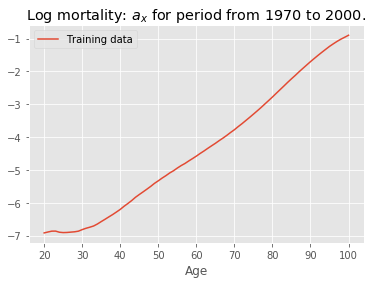

In [14]:
train_data_log_mean.plot(title=f'Log mortality: $a_x$ for period from {train_data_log.columns.min()} to {train_data_log.columns.max()}.', label='Training data')
plt.legend();

# Models' calibration

## Autoencoders

In [15]:
#remove randomness
def reset_seeds():
    os.environ['PYTHONHASHSEED'] = str(1)
    tf.random.set_random_seed(1)
    np.random.seed(1)
    random.seed(1)

In [16]:
#define loss function (root mean square error) as in the paper
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [17]:
#define activation function as in the paper
def tanh_sigmoid(x):
    return 2 / (1 + K.exp(-x)) - 1

In [18]:
train_data_log.head()

Year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
Age,,,,,,,,,,,,,,,,,,,,,
20,-6.751607,-6.671103,-6.605431,-6.564166,-6.627098,-6.643854,-6.693451,-6.660114,-6.761925,-6.703998,...,-7.059742,-7.112322,-7.085686,-7.178253,-7.207510,-7.234871,-7.196772,-7.299317,-7.274481,-7.271599
21,-6.816088,-6.707266,-6.579891,-6.635441,-6.726267,-6.699928,-6.645391,-6.720446,-6.684612,-6.681417,...,-6.946496,-7.090477,-7.014228,-7.100127,-7.147282,-7.225210,-7.274481,-7.243228,-7.149827,-7.289016
22,-6.739702,-6.661677,-6.657775,-6.702368,-6.774974,-6.731284,-6.671103,-6.656997,-6.741394,-6.679027,...,-6.963268,-6.970695,-6.927958,-6.959049,-7.080919,-7.135911,-7.127156,-7.137168,-7.206161,-7.270161
23,-6.748191,-6.717962,-6.642319,-6.629366,-6.767993,-6.826175,-6.691838,-6.729609,-6.808815,-6.740547,...,-6.886973,-6.926938,-6.926938,-7.013116,-7.017570,-7.031053,-7.180877,-7.076174,-7.183509,-7.286092
24,-6.817001,-6.758474,-6.740547,-6.737169,-6.800696,-6.834505,-6.778483,-6.813355,-6.846660,-6.798004,...,-6.878196,-6.907755,-7.015340,-6.994403,-7.052781,-7.119712,-7.135911,-7.191445,-7.111096,-7.267291


In [19]:
X_t = train_data_log.sub(train_data_log_mean, axis=0).T
X_t_valid = valid_data_log.sub(train_data_log_mean, axis=0).T

In [20]:
reset_seeds()

input_dim = train_data_log.shape[0]
outer_dim = 4
inner_dim = 3

input_layer = Input(shape=(input_dim, ), name='input_layer')

x = Dense(outer_dim, activation=tanh_sigmoid, name='encoder_1')(input_layer)
encoded = Dense(inner_dim, activation='linear', name='encoder_2')(x)
x = Dense(outer_dim, activation=tanh_sigmoid, name='decoder_1')(encoded)
decoded = Dense(input_dim, activation='linear', name='decoder_2')(x)

reset_seeds()

#set up full model
autoencoder = Model(input_layer, decoded)

#set up encoder model
encoder = Model(input_layer, encoded)

#set up decoder function
encoded_input = Input(shape=(inner_dim,))
x = autoencoder.layers[-2](encoded_input)
decoded_layer = autoencoder.layers[-1](x)

decoder = Model(encoded_input, decoded_layer)

autoencoder.summary()
encoder.summary()
decoder.summary()

autoencoder.compile(optimizer='rmsprop', loss=rmse)
history = autoencoder.fit(X_t, X_t,
                            epochs=2000,
                            verbose=False,
                            validation_data=(X_t_valid, X_t_valid))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 81)                0         
_________________________________________________________________
encoder_1 (Dense)            (None, 4)                 328       
_________________________________________________________________
encoder_2 (Dense)            (None, 3)                 15        
_________________________________________________________________
decoder_1 (Dense)            (None, 4)                 16        
_________________________________________________________________
decoder_2 (Dense)            (None, 81)                405       
Total params: 764
Trainable params: 764
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer 

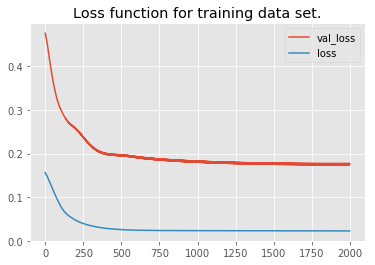

In [21]:
pd.DataFrame(history.history).plot(title='Loss function for training data set.');

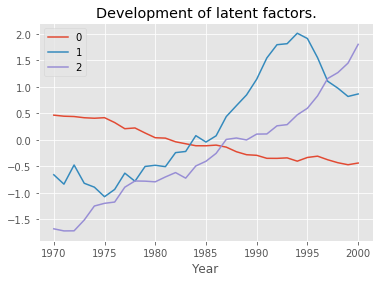

In [22]:
kt_ae = pd.DataFrame(encoder.predict(X_t), index=train_data_log.T.index)
kt_ae.plot()
plt.title('Development of latent factors.');

In [23]:
def jb_test_ae(df):
    for c in df.columns:
        jb_stat, p_value = stats.jarque_bera(df[c].diff()[1:])
        print('--- JB for column %s ---' % c)
        print('JB test statistic equal to: %0.4f' % jb_stat)
        print('p-value equal to: %0.4f' % p_value)

#JB test for normality of differences in the development of latent factors
jb_test_ae(kt_ae)

--- JB for column 0 ---
JB test statistic equal to: 0.3943
p-value equal to: 0.8211
--- JB for column 1 ---
JB test statistic equal to: 1.5173
p-value equal to: 0.4683
--- JB for column 2 ---
JB test statistic equal to: 1.0586
p-value equal to: 0.5890


In [24]:
#check if encoder->decoder and autoencoder give the same results
np.allclose(decoder.predict(encoder.predict(X_t)), autoencoder.predict(X_t))

True

In [25]:
def calc_goodness_of_fit(act_mort, pred_mort):
    sum_se = (act_mort.sub(pred_mort)**2).sum().sum()
    avg_error = act_mort.sub(pred_mort).mean().mean()
    max_error = act_mort.sub(pred_mort).max().max()
    min_error = act_mort.sub(pred_mort).min().min()
    return sum_se, avg_error, max_error, min_error

In [26]:
sum_se, avg_error, max_error, min_error = calc_goodness_of_fit(X_t, autoencoder.predict(X_t))
print('Sum of squared errors: %0.2f' % sum_se)
print('Average error: %0.4f' % avg_error)
print('Maximum error: %0.4f' % max_error)
print('Minimum error: %0.4f' % min_error)

Sum of squared errors: 1.39
Average error: 0.0007
Maximum error: 0.0953
Minimum error: -0.1366


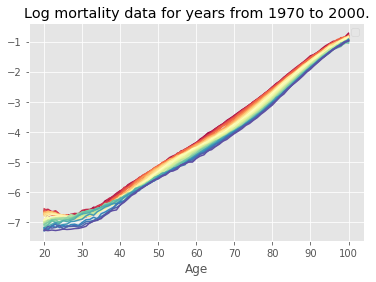

In [27]:
train_data_log.plot(colormap="Spectral")
plt.title('Log mortality data for years from {} to {}.'.format(train_data_log.columns.min(), train_data_log.columns.max()))
plt.legend('')
plt.show();

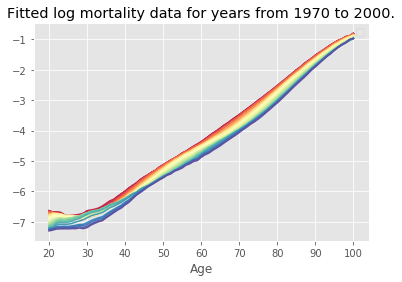

In [28]:
fitted_data_log = pd.DataFrame(autoencoder.predict(X_t).T, index=train_data_log.index, columns=train_data_log.columns)
fitted_data_log.add(train_data_log_mean, axis=0).plot(colormap="Spectral")
plt.title('Fitted log mortality data for years from {} to {}.'.format(train_data_log.columns.min(), train_data_log.columns.max()))
plt.legend('')
plt.show();

## Lee-Carter model

In [77]:
#LeeCarter model with one latent factor
lc_1 = LeeCarter(no_latent_factors=1)
lc_1.fit(train_data_log)

Model fitted.


In [78]:
sum_se, avg_error, max_error, min_error = calc_goodness_of_fit(lc_1.predict(train_data_log), train_data_log)
print('Sum of squared errors: %0.2f' % sum_se)
print('Average error: %0.4f' % avg_error)
print('Maximum error: %0.4f' % max_error)
print('Minimum error: %0.4f' % min_error)

Sum of squared errors: 5.66
Average error: -0.0000
Maximum error: 0.2525
Minimum error: -0.2207


In [80]:
def jb_test_lc(model):
    diffs = model.kts.diff()[1:]
    for c in diffs.columns:
        jb_stat, p_value = stats.jarque_bera(diffs[c])
        print('JB test statistic is equal to: %0.4f' % (jb_stat))
        print('p-value equal to: %0.4f' % (p_value))
jb_test_lc(lc_1)

JB test statistic is equal to: 0.5395
p-value equal to: 0.7636


In [82]:
lc_models = []
for f in range(3):
    #fit LeeCarter model with 1-3 latent factors
    
    print('--- Fitting LeeCarter model with %s latent factor(s) ---' % str(f+1))
    lc = LeeCarter(no_latent_factors=f+1)
    lc.fit(train_data_log)
    lc_models.append(lc)

--- Fitting LeeCarter model with 1 latent factor(s) ---
Model fitted.
--- Fitting LeeCarter model with 2 latent factor(s) ---
Model fitted.
--- Fitting LeeCarter model with 3 latent factor(s) ---
Model fitted.


In [83]:
sum_se, avg_error, max_error, min_error = calc_goodness_of_fit(lc_models[0].predict(train_data_log), train_data_log)
print('Sum of squared errors: %0.2f' % sum_se)
print('Average error: %0.4f' % avg_error)
print('Maximum error: %0.4f' % max_error)
print('Minimum error: %0.4f' % min_error)

Sum of squared errors: 5.66
Average error: -0.0000
Maximum error: 0.2525
Minimum error: -0.2207


In [84]:
sum_se, avg_error, max_error, min_error = calc_goodness_of_fit(lc_models[1].predict(train_data_log), train_data_log)
print('Sum of squared errors: %0.2f' % sum_se)
print('Average error: %0.4f' % avg_error)
print('Maximum error: %0.4f' % max_error)
print('Minimum error: %0.4f' % min_error)

Sum of squared errors: 2.44
Average error: -0.0000
Maximum error: 0.2017
Minimum error: -0.1150


In [85]:
sum_se, avg_error, max_error, min_error = calc_goodness_of_fit(lc_models[2].predict(train_data_log), train_data_log)
print('Sum of squared errors: %0.2f' % sum_se)
print('Average error: %0.4f' % avg_error)
print('Maximum error: %0.4f' % max_error)
print('Minimum error: %0.4f' % min_error)

Sum of squared errors: 1.39
Average error: -0.0000
Maximum error: 0.1098
Minimum error: -0.0910


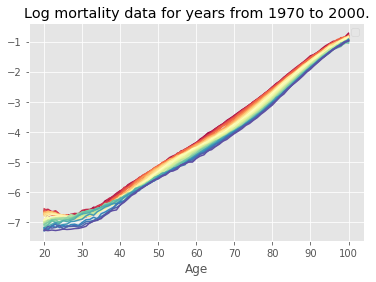

In [86]:
train_data_log.plot(colormap="Spectral")
plt.title('Log mortality data for years from {} to {}.'.format(train_data_log.columns.min(), train_data_log.columns.max()))
plt.legend('')
plt.show();

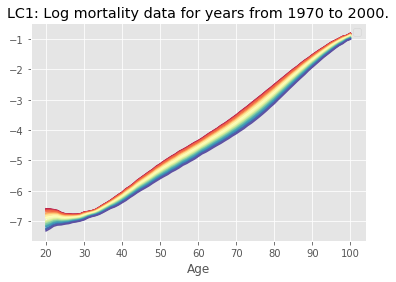

In [87]:
lc_models[0].predict(train_data_log).plot(colormap="Spectral")
plt.title('LC1: Log mortality data for years from {} to {}.'.format(train_data_log.columns.min(), train_data_log.columns.max()))
plt.legend('')
plt.show();

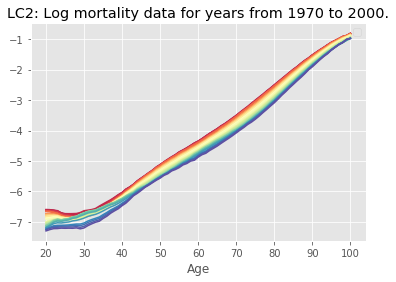

In [88]:
lc_models[1].predict(train_data_log).plot(colormap="Spectral")
plt.title('LC2: Log mortality data for years from {} to {}.'.format(train_data_log.columns.min(), train_data_log.columns.max()))
plt.legend('')
plt.show();

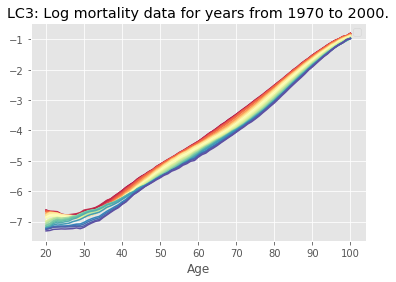

In [89]:
lc_models[2].predict(train_data_log).plot(colormap="Spectral")
plt.title('LC3: Log mortality data for years from {} to {}.'.format(train_data_log.columns.min(), train_data_log.columns.max()))
plt.legend('')
plt.show();

## Simulations and prediction

In [90]:
def draw_simulations(df, no_sims=10000, no_years=20):

    diffs = df.diff()[1:].describe()
    simulations = {}

    mean_simulations = {}
    for c in diffs.columns:
        mu = diffs[c].loc['mean']
        sigma = diffs[c].loc['std']
        simulations[c] = np.random.normal(mu, sigma, (no_sims, no_years))

    for i in simulations.keys():
        mean_simulations[i] = simulations[i].mean(axis=0)

    simulations_df = pd.DataFrame(mean_simulations, index=range(df.index.max() + 1, df.index.max() + 1 + no_years))
    simulations_df.index.name = 'Year'

    diffs_cum = df.iloc[[0]].append(df.diff()[1:].append(simulations_df))
    diffs_cum = diffs_cum.cumsum()

    return diffs_cum

In [91]:
def plot_kts(kts):
    if(len(kts.columns)==1):
        kts.plot()
        plt.legend("")
    else:
        fig, axs = plt.subplots(ncols=len(kts.columns), figsize=(14,5))    
        for i, c in enumerate(kts.columns):
            sns.lineplot(kts.index, kts.iloc[:,i], ax=axs[i])
    plt.show()

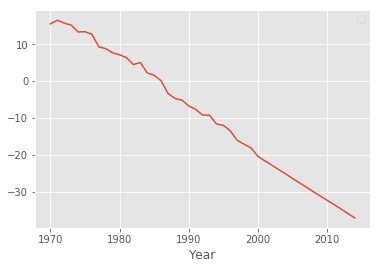

In [92]:
kt_lc1 = lc_models[0].kts
sims_lc1 = draw_simulations(kt_lc1, no_sims=1000, no_years=14)
plot_kts(sims_lc1)

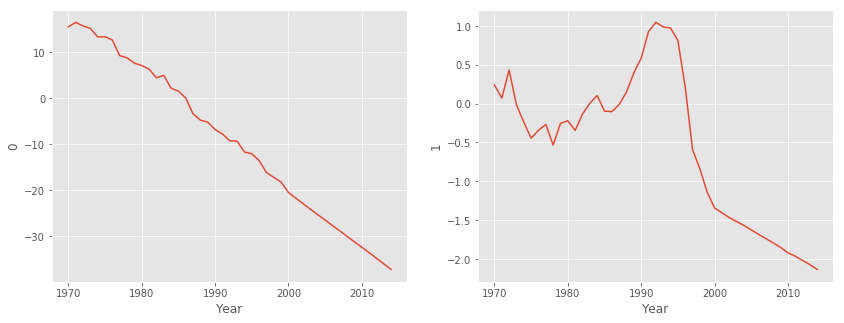

In [93]:
kt_lc2 = lc_models[1].kts
sims_lc2 = draw_simulations(kt_lc2, no_sims=1000, no_years=14)
plot_kts(sims_lc2)

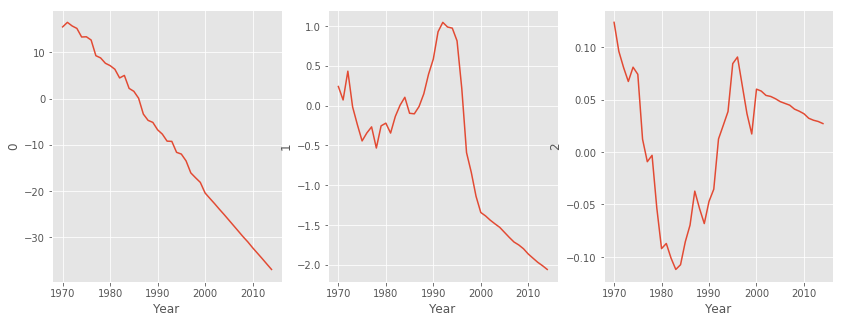

In [94]:
kt_lc3 = lc_models[2].kts
sims_lc3 = draw_simulations(kt_lc3, no_sims=1000, no_years=14)
plot_kts(sims_lc3)